# PopStar Quick Start: Making A Cluster

This is a quick start guide to making a synthetic cluster using the PopStar package. The cluster is constructed using a user-specified isochrone and initial mass function (IMF). Detailed documentation with all the available options to the user at each step is provided in [XXX].

Before starting this tutorial, it is assumed that PopStar has been installed and the user's python path has been altered to include the PopStar top-level directory

In [1]:
# Import necessary packages. 
from popstar import synthetic, evolution, atmospheres, reddening, ifmr
from popstar.imf import imf, multiplicity
import numpy as np
import pylab as py
import pdb

/anaconda/envs/microlens/lib/python3.5/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in /g/lu/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/anaconda/envs/microlens/lib/python3.5/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /g/lu/models/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


#### Step 1: Make a PopStar isochrone object

The cluster is made from a theoretical isochrone at a given age, extinction, and distance from Earth. These parameters MUST be specified by the user. Other inputs (e.g. stellar evolution/atmosphere models, extinction law, and photometric filters used) are optional keywords. See documentation for all keywords and their default values.

Here, we create a 5 Myr cluster isochrone at an extinction of 0.8 mags and distance of 4000 pc from Earth.

In [2]:
# Define isochrone parameters
logAge = np.log10(5*10**6.) # Age in log(years)
AKs = 0.8 # extinction in mags
dist = 4000 # distance in parsec

# Define evolution/atmosphere models and extinction law (optional)
evo_model = evolution.MergedBaraffePisaEkstromParsec() 
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18()

# Also specify filters for synthetic photometry (optional). Here we use 
# the HST WFC3-IR F127M, F139M, and F153M filters
filt_list = ['wfc3,ir,f127m', 'wfc3,ir,f139m', 'wfc3,ir,f153m']

# Make Isochrone object. Note that is calculation will take a few minutes, unless the 
# isochrone has been generated previously.
my_iso = synthetic.IsochronePhot(logAge, AKs, dist,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list)

Once calculated, the isochrone will be written as a fits file to a location set by the "iso_dir" keyword (not shown here; default location is current working directory). In the future, the IsochronePhot function will read this file directly rather than recalculating the isochrone again. 

The file name will be the following: "iso_logAge_AKs_distance.fits, using the specified values

In [3]:
# The individual points in the isochrone can be accessed using the points subfunction 
# on the isochrone object. This produces an astropy table that contains the 
# list of stellar masses in the isochrone and their associated properties
print(my_iso.points)

        L              Teff           R       ...  m_hst_f139m   m_hst_f153m 
        W               K             m       ...                            
----------------- ------------- ------------- ... ------------- -------------
6.59131290505e+24 2928.19503557  354711646.61 ... 22.4265369121 21.6837096022
7.13135291245e+24 2943.74373371 365069413.693 ... 22.3382585257 21.5958442996
7.76196945033e+24 2958.69365251 377029600.886 ... 22.2442180038 21.5020817303
 8.2960608547e+24 2975.08925888 385500946.191 ... 22.1700102814 21.4283838524
8.83022823842e+24 2992.26463661  393165542.14 ...  22.100768472 21.3596868429
8.86077949607e+24 3009.53916887 389336793.989 ... 22.0957325354 21.3562038866
8.88938936324e+24  3026.9134281 385500946.191 ... 22.0920363516 21.3541184665
1.13650651357e+25 3065.49067943 424986807.021 ... 21.8278398877 21.0910259514
 1.3837955482e+25 3103.84481916 457430847.306 ... 21.6176976523 20.8816107684
1.63144309116e+25 3142.67882988  484479548.04 ... 21.4376208042 

In [4]:
print('The columns in the isochrone table are: {0}'.format(my_iso.points.keys()))

The columns in the isochrone table are: ['L', 'Teff', 'R', 'mass', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m']


In [5]:
# Identify a 1 M_sun star, print F127M, F139M, and F153M mags
idx = np.where( abs(my_iso.points['mass'] - 1.0) == min(abs(my_iso.points['mass'] - 1.0)) )[0]
f127m = np.round(my_iso.points[idx[0]]['m_hst_f127m'], decimals=3)
f139m = np.round(my_iso.points[idx[0]]['m_hst_f139m'], decimals=3)
f153m = np.round(my_iso.points[idx[0]]['m_hst_f153m'], decimals=3)
print('1 M_sun: F127M = {0} mag, F139M = {1} mag, F153M = {2} mag'.format(f127m, f139m, f153m))

1 M_sun: F127M = 19.389 mag, F139M = 18.77 mag, F153M = 18.014 mag


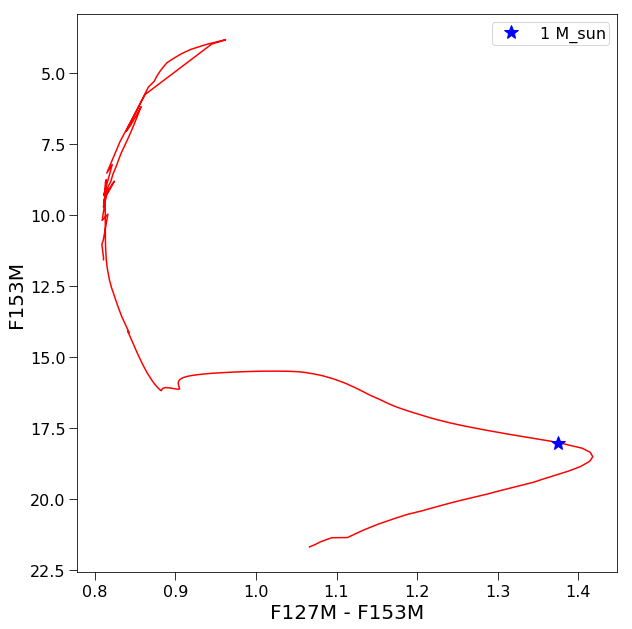

In [6]:
# Make a color-magnitude diagram
py.figure(1, figsize=(10,10))
py.clf()
py.plot(my_iso.points['m_hst_f127m'] - my_iso.points['m_hst_f153m'], 
       my_iso.points['m_hst_f153m'], 'r-', label='_nolegend_')
py.plot(my_iso.points['m_hst_f127m'][idx] - my_iso.points['m_hst_f153m'][idx], 
       my_iso.points['m_hst_f153m'][idx], 'b*', ms=15, label='1 M_sun')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

### Step 2: Make an Initial Mass Function

PopStar offers a range of initial mass functions (IMFs) a user can use from to make the cluster. In addition to the parameters defining the IMF, the user can pass in a PopStar multiplicity object, which defines the multiplicity properties of the population. The default multiplicity is None (e.g. all stars are single).

Here we define a Kroupa IMF using the Multiplicity properties defined in Lu+13. 

In [7]:
# Make multiplicity object
imf_multi = multiplicity.MultiplicityUnresolved()

# Make IMF object; we'll use a broken power law with the parameters from Kroupa+01
massLimits = np.array([0.08, 0.5, 1, 120]) # Define boundaries of each mass segement
powers = np.array([-1.3, -2.3, -2.3]) # Power law slope associated with each mass segment
my_imf = imf.IMF_broken_powerlaw(massLimits, powers, imf_multi)

## Note: there is a Kroupa_2001 IMF object in the popstar/imf.py that one could use
## to generate the Kroupa+01 IMF. However, the Kroupa_2001 IMF object contains masses
## down to 0.01 M_sun, which is beyond the lower limit of our isochrones. As a result,
## the synthetic photometry of these stars systems are non-sensical 
##
## If the user isn't interested in the photometry, then they could define the 
## IMF object as:
## my_imf = imf.Kroupa_2001(multiplicity=imf_multi)

### Step 3: Make the Cluster  
#### Option 1: No compact objects
To create the cluster, the user passes in an isochrone object, and imf object, and specifies the total cluster mass. Here we will make a 10^5 M_sun cluster using the isochrone and imf we have defined.

The individual star systems in the cluster and their properties are stored in an astropy table accessed by the star_systems subfunction on the cluster object. Note that the photometry of these star systems includes the contributions from all companions, which are generated probabilistically using the multiplicity defined in the IMF object.

In [8]:
# Define total cluster mass
mass = 10**5.

# Make cluster object
cluster = synthetic.ResolvedCluster(my_iso, my_imf, mass)

# Look at star systems table
print(cluster.star_systems)

Found 34 stars out of mass range
      mass      isMultiple    systemMass   ...  m_hst_f153m  N_companions
--------------- ---------- --------------- ... ------------- ------------
 0.132830693466      False  0.132830693466 ... 20.9566788504            0
0.0907409169662      False 0.0907409169662 ... 21.3591707266            0
 0.580686610407      False  0.580686610407 ... 18.8118699199            0
 0.944869092781       True   1.57545070565 ... 17.6014844877            1
  0.45690636941       True  0.845635125624 ...  18.547285253            1
 0.957542427323      False  0.957542427323 ... 18.0773634878            0
 0.307255316571      False  0.307255316571 ... 19.7932215064            0
  1.04319865604       True   1.54061173817 ... 17.6007904869            1
  0.25707674311      False   0.25707674311 ... 20.0389456097            0
  1.63443027301       True   2.77465735602 ... 16.5780634183            2
            ...        ...             ... ...           ...          ...
 0.25

In [9]:
print('The cluster table contains these columns: {0}'.format(cluster.star_systems.keys()))

The cluster table contains these columns: ['mass', 'isMultiple', 'systemMass', 'Teff', 'L', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m', 'N_companions']


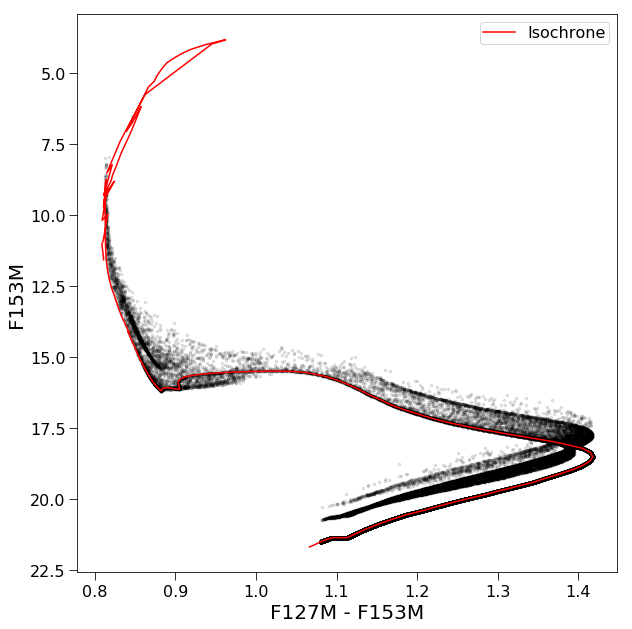

In [10]:
# Look at the cluster CMD, compared to input isochrone. Note the impact of
# multiple systems on the photometry
clust = cluster.star_systems
iso = my_iso.points

py.figure(2, figsize=(10,10))
py.clf()
py.plot(clust['m_hst_f127m'] - clust['m_hst_f153m'], clust['m_hst_f153m'],
       'k.', ms=5, alpha=0.1, label='__nolegend__')
py.plot(iso['m_hst_f127m'] - iso['m_hst_f153m'], iso['m_hst_f153m'],
       'r-', label='Isochrone')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

#### Option 2: Compact objects (white dwarfs, neutron stars, and black holes)
This is quite similar to the above, but includes compact objects. The additional piece of information required is to choose an initial-final mass relation (IFMR.) Currently there's only one choice in PopStar, so that makes your decision easy.

In [11]:
# Create isochrone object                                                                                                                                                  
my_ifmr = ifmr.IFMR()
my_iso = synthetic.IsochronePhot(9, 0, 10,
                                 evo_model = evolution.MISTv1())

# Create IMF object                                                                                                                                                        
massLimits = np.array([0.1, 0.5, 120])
powers = np.array([-1.3, -2.3])
trunc_kroupa = imf.IMF_broken_powerlaw(massLimits, powers)

# Make cluster                                                                                                                                                             
cluster_mass = 10**6
cluster = synthetic.ResolvedCluster(my_iso, trunc_kroupa, cluster_mass, ifmr=my_ifmr)
output = cluster.star_systems

In [12]:
print(output.colnames)

['mass', 'isMultiple', 'systemMass', 'Teff', 'L', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_ubv_V', 'm_hst_f160w', 'm_hst_f153m', 'm_ubv_B', 'm_ubv_I', 'm_ubv_U', 'm_ubv_R', 'm_nirc2_H', 'm_nirc2_J', 'm_hst_f125w', 'm_hst_f814w', 'm_nirc2_Kp']


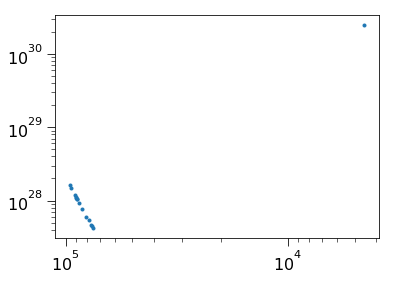

In [16]:
# Plot "HR" diagram
# Not sure what is up with that point in the right corner...
# THIS PLOT NEEDS UNITSSSS
wd_idx = np.where(output['phase'] == 6)[0]
lum = output['L'][wd_idx]
temp = output['Teff'][wd_idx]
py.plot(temp, lum, '.')
py.gca().invert_xaxis()
py.xscale('log')
py.yscale('log')
py.show()

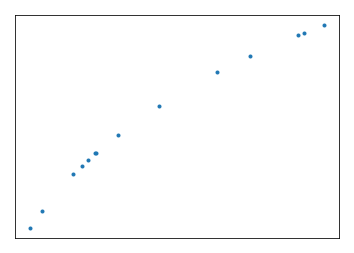

In [20]:
# The MIST (luminous) WDs
wd_idx = np.where((output['phase'] == 6) & (output['logg'] > 1))[0]
mass = output['mass'][wd_idx]
radius = np.sqrt(output['mass'][wd_idx] / output['logg'][wd_idx])
py.plot(mass, output['logg'][wd_idx], '.')
#py.plot(mass, radius, '.')
py.xscale('log')
py.yscale('log')
py.show()